#### load libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate, GridSearchCV, train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### load and inspect data

In [6]:
house_df = pd.read_csv('../data/final_df.csv', index_col = 0)

# Checking final_df after generating geoCode, found duplicated observations
house_df.shape

(2603, 179)

In [7]:
# drop duplicated observations
house_df = house_df.drop_duplicates(subset=['PID'],keep = 'first')
house_df.shape

(2558, 179)

#### additional preprocessing

In [8]:
house_df_use = house_df.copy()

# convert MSSubClass to str
house_df_use['MSSubClass'] = house_df_use[['MSSubClass']].astype('str')

# characterize tax distr and sch distr
house_df_use['TxD_S'] = house_df_use[['TxD_S']].astype('str')
house_df_use['SchD_S'] = house_df_use[['SchD_S']].astype('str')

# convert NA's to 0s in LotFrontage
house_df_use['LotFrontage'] = np.where(np.isnan(house_df_use['LotFrontage']), 0, house_df_use['LotFrontage'])

# Impute None to Nan value in columns
none_features = ['FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','Fence','BsmtQual','BsmtCond']
for feature in none_features:
    house_df_use[feature] = house_df_use[feature].fillna('None')

# drop rows with NA garage car / garage
garage_NA_index = house_df_use.loc[pd.isnull(house_df_use['GarageArea'])].index
house_df_use = house_df_use.drop(garage_NA_index,axis=0)

# remove unnecessary columns
house_df_use = house_df_use.drop(
    ['PA-PreD','PA-PostD','PA-UnTyp','PA-UntNo','X1TPr_D','X1TSc_D','Rcrd_Mo','Legal_Pr','TxD_S',\
    'X2TPr_D','X2TSc_D','X1TPr_S','X1TSc_S','X2TPr_S','X2TSc_S','ISU_lat_long','address','MA_Ownr1','MA_Ownr2',\
    'MA_Line1','MA_Line2','MA_City','MA_State','address3','location2','point2','SaleCond','Source','Date',\
    'ParType','BldgNo_S','DwlgNo_S','YrBuilt','Ext1','Ext2','GLA','GarYrBlt','Cars','MA_Zip1','MA_Zip2',\
    'ZngCdPr','ZngCdSc','ZngOLPr','ZngOLSc','PA-Nmbr','PA-Strt','PA-StSfx','Inst1_No','Inst1_Yr','Inst1_Mo',\
    'Inst1TPr','TtlVal_AsrYr','ValType','OthAc_S','ImpAc_S','LndAc_S','Prop_Addr','HSTtl_D','MilVal_D',\
    'HSTtl_S','MilVal_S','GeoRefNo','Tier','Range','AcreX_S1','ClassPr_S','ClassSc_S','LndAcX1S','ImpAcX1S',\
    'Central Air','ImpAcX2S','AcreGr','AcreNt_S','ParclRel','Rcrd_Yr','address2',\
    'latitude2','longitude2','ISU_lat','ISU_long','altitude2','Central Air',\

    'index','MiscVal','YrSold_YYYY','MoSold_MM','PoolArea','PoolQC','MiscFeature','Street','PID','Utilities',\
    'BsmtHalfBath2','FullBath','HalfBath','TtlBsmtSF','HalfBath2','BsmtFullBath','BsmtHalfBath',\
    'BsmtFinSF1','BsmtFinSF2','BsmtFinType1','BsmtFinType2','BsmtUnfSF','LowQualFinSF','BasmtFinSF2','BasmtFinSF1',\
    'GrLivArea','1stFlrSF','2ndFlrSF','MasVnrType','MasVnrArea','GarageArea2','PoolArea2','NmbrBRs',\
    'Neighborhood','BedroomAbvGr','num_bathroom','TotalBsmtSF','GarageYrBlt','BasmtFinSF','Heating'],\
    axis=1)

print(house_df_use.columns)
print(f'has null: {house_df_use.columns[house_df_use.isnull().sum() > 0]}')

Index(['SalePrice', 'Distance', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'Fence', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'MasVnrArea2', 'total_LivArea', 'SchD_S'],
      dtype='object')
has null: Index(['Alley', 'BsmtExposure', 'Electrical'], dtype='object')


#### test-train split

In [9]:
len(house_df[house_df['YrSold']==2010])

314

In [10]:
train = house_df_use[house_df_use['YrSold']!=2010]
test = house_df_use[house_df_use['YrSold']==2010]
print(train.shape)
print(test.shape)
X_train = train.drop(['SalePrice'],axis=1)
y_train = train['SalePrice']
X_test = test.drop(['SalePrice'],axis=1)
y_test = test['SalePrice']

(2243, 58)
(314, 58)


#### minimum sample/class size

In [389]:
(1.96 * statistics.stdev(y_train) / 20000)**2

54.14528316148

#### correlations among numeric variables

In [390]:
X_num = X_train.describe().columns
print(X_num)
train_num = pd.concat([X_train[X_num], y_train], axis = 1)

train_num.corr()[['SalePrice','total_LivArea','OverallQual','GarageCars','GarageArea','YearBuilt','YearRemodAdd',\
                  'Fireplaces','TotRmsAbvGrd','Distance']].sort_values('SalePrice', ascending = False)

Index(['Distance', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MoSold', 'YrSold',
       'MasVnrArea2', 'total_LivArea'],
      dtype='object')


,SalePrice,total_LivArea,OverallQual,GarageCars,GarageArea,YearBuilt,YearRemodAdd,Fireplaces,TotRmsAbvGrd,Distance
SalePrice,1.000000,0.821822,0.795343,0.641047,0.638928,0.544119,0.515411,0.492058,0.487020,0.197630
total_LivArea,0.821822,1.000000,0.626566,0.549490,0.541652,0.414829,0.407311,0.459919,0.558998,0.156385
OverallQual,0.795343,0.626566,1.000000,0.580640,0.537988,0.576069,0.546757,0.397097,0.371285,0.205001
GarageCars,0.641047,0.549490,0.580640,1.000000,0.889582,0.519465,0.396496,0.326291,0.367835,0.269506
GarageArea,0.638928,0.541652,0.537988,0.889582,1.000000,0.467990,0.345984,0.291355,0.329069,0.245834
YearBuilt,0.544119,0.414829,0.576069,0.519465,0.467990,1.000000,0.574421,0.169338,0.096496,0.516303
YearRemodAdd,0.515411,0.407311,0.546757,0.396496,0.345984,0.574421,1.000000,0.127481,0.190178,0.319149
Fireplaces,0.492058,0.459919,0.397097,0.326291,0.291355,0.169338,0.127481,1.000000,0.303843,-0.029324
TotRmsAbvGrd,0.487020,0.558998,0.371285,0.367835,0.329069,0.096496,0.190178,0.303843,1.000000,0.002205
MasVnrArea2,0.388038,0.338098,0.388133,0.358467,0.328935,0.413023,0.214166,0.222266,0.187397,0.162697


#### inspect qual/cond variables

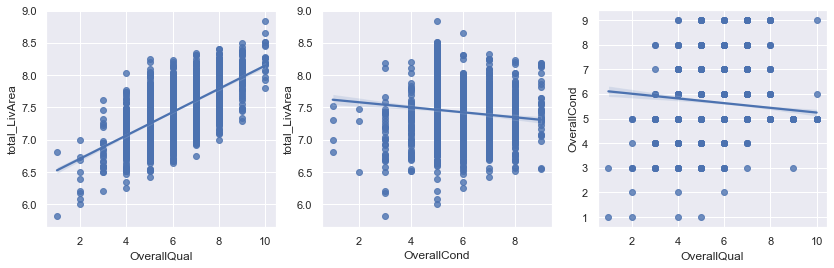

In [391]:
sns.set(rc={'figure.figsize':(14, 4)})
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False)
sns.regplot(x = X_train['OverallQual'], y = np.log(X_train['total_LivArea']), ax = ax1)
sns.regplot(x = X_train['OverallCond'], y = np.log(X_train['total_LivArea']), ax = ax2)
sns.regplot(x = X_train['OverallQual'], y = X_train['OverallCond'], ax = ax3)

In [392]:
qual = [col for col in X_train.columns if col.lower().find('qu') != -1]
X_train[qual].apply(set)

OverallQual    {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
ExterQual                     {Gd, Fa, TA, Ex}
BsmtQual            {Gd, Po, None, TA, Fa, Ex}
KitchenQual                   {Gd, Fa, TA, Ex}
FireplaceQu         {Gd, Po, None, TA, Fa, Ex}
GarageQual          {Gd, Po, None, TA, Fa, Ex}
dtype: object

In [393]:
cond = [col for col in X_train.columns if col.lower().find('cond') != -1]
X_train[cond].drop(['Condition1','Condition2','SaleCondition'], axis=1).apply(set)

OverallCond    {1, 2, 3, 4, 5, 6, 7, 8, 9}
ExterCond                 {Gd, Fa, TA, Ex}
BsmtCond        {Gd, Po, None, TA, Fa, Ex}
GarageCond      {Gd, Po, None, TA, Fa, Ex}
dtype: object

In [356]:
qual_dum = pd.get_dummies(X_train[['total_LivArea','OverallQual','ExterQual','BsmtQual','KitchenQual',\
                                   'FireplaceQu','GarageQual']])
cond_dum = pd.get_dummies(X_train[['total_LivArea','OverallCond','ExterCond','GarageCond','BsmtCond']])

In [357]:
qual_dum.corr().sort_values('total_LivArea', ascending = False)
#cond_dum.corr().sort_values('total_LivArea', ascending = False)

,total_LivArea,OverallQual,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_Po,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA
total_LivArea,1.000000,0.626566,0.299980,-0.095345,0.369231,-0.442391,0.440252,-0.134553,0.253162,-0.115192,-0.025640,-0.401165,0.377635,-0.122072,0.278258,-0.411400,0.206146,-0.002694,0.231049,-0.437084,-0.056714,0.244789,0.002368,-0.145418,0.079833,-0.150263,-0.035445,0.184093
OverallQual,0.626566,1.000000,0.363196,-0.173777,0.553425,-0.626556,0.465776,-0.163762,0.355328,-0.208325,-0.045388,-0.475203,0.406651,-0.191620,0.414916,-0.537299,0.187291,-0.022516,0.328983,-0.433158,-0.077635,0.158824,0.025050,-0.171276,0.048972,-0.230330,-0.033167,0.263522
BsmtQual_Ex,0.440252,0.465776,0.487166,-0.030403,0.168080,-0.325143,1.000000,-0.049862,-0.242562,-0.046657,-0.008555,-0.259181,0.520119,-0.044978,0.021216,-0.250311,0.221236,-0.037036,0.264495,-0.203590,-0.037593,-0.065637,-0.010480,-0.062505,0.028673,-0.063779,-0.012104,0.081201
KitchenQual_Ex,0.377635,0.406651,0.599258,-0.008159,0.065379,-0.268604,0.520119,-0.020607,-0.094036,-0.028390,-0.007410,-0.166967,1.000000,-0.038958,-0.199677,-0.260634,0.275857,-0.041122,0.223087,-0.177465,-0.032562,-0.069750,0.043129,-0.017508,0.018712,-0.046250,-0.010484,0.034718
ExterQual_Gd,0.369231,0.553425,-0.120254,-0.074495,1.000000,-0.916397,0.168080,-0.082898,0.486171,-0.102372,-0.020962,-0.509274,0.065379,-0.104021,0.634801,-0.619581,0.083498,-0.034055,0.163757,-0.210270,-0.070071,0.093970,0.000266,-0.121296,0.038609,-0.124993,-0.029658,0.161923
ExterQual_Ex,0.299980,0.363196,1.000000,-0.018195,-0.120254,-0.223825,0.487166,-0.029840,-0.096298,-0.027922,-0.005120,-0.144346,0.599258,-0.026918,-0.105072,-0.169358,0.160029,-0.028413,0.214159,-0.151499,-0.022498,-0.066736,-0.006272,-0.037407,0.013379,-0.038169,-0.007244,0.049730
KitchenQual_Gd,0.278258,0.414916,-0.105072,-0.059384,0.634801,-0.569189,0.021216,-0.096961,0.445174,-0.102404,-0.024049,-0.385536,-0.199677,-0.126438,1.000000,-0.845892,-0.004488,-0.014670,0.115797,-0.147748,-0.056173,0.081776,-0.029461,-0.114378,0.035143,-0.101865,-0.034026,0.146349
BsmtQual_Gd,0.253162,0.355328,-0.096298,-0.081316,0.486171,-0.422667,-0.242562,-0.147483,1.000000,-0.138002,-0.025304,-0.766615,-0.094036,-0.115344,0.445174,-0.356034,-0.025672,0.005240,-0.020878,-0.153562,-0.034143,0.220843,-0.030998,-0.150169,-0.009244,-0.086401,-0.035801,0.173745
FireplaceQu_TA,0.244789,0.158824,-0.066736,-0.057228,0.093970,-0.056068,-0.065637,-0.068591,0.220843,-0.034020,-0.016103,-0.148886,-0.069750,-0.042881,0.081776,-0.034189,-0.064849,-0.089365,-0.306497,-0.510248,-0.070763,1.000000,0.009479,-0.092039,0.031706,-0.104961,-0.022784,0.128096
FireplaceQu_Gd,0.231049,0.328983,0.214159,-0.040600,0.163757,-0.224549,0.264495,-0.056024,-0.020878,-0.046876,-0.016986,-0.085003,0.223087,-0.028383,0.115797,-0.208935,-0.068405,-0.094266,1.000000,-0.538228,-0.074644,-0.306497,0.007582,0.000397,0.015375,-0.097296,-0.024033,0.065069


#### initial testing

In [394]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
print(X_train.shape)
print(len(X_train_dum.columns))

# apply log to area and house price
X_train_dum['LotFrontage'] = np.log(X_train_dum['LotFrontage']+1)
X_train_dum['LotArea'] = np.log(X_train_dum['LotArea']+1)
X_train_dum['total_LivArea'] = np.log(X_train_dum['total_LivArea'])
X_train_dum['Distance'] = np.log(X_train_dum['Distance'])
#X_train_dum['Total_porch_sf'] = np.log(X_train_dum['Total_porch_sf']+1)
y_train = np.log(y_train)

(2243, 57)
206


In [395]:
lin_reg = LinearRegression().fit(X_train_dum, y_train)
lin_reg.score(X_train_dum,y_train)

x_feature = sm.add_constant(X_train_dum)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

X_vif = X_train_dum[pValue[pValue<0.05].drop('const').index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)

0.9353574159932945

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     146.9
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:08:08   Log-Likelihood:                 2046.3
No. Observations:                2243   AIC:                            -3689.
Df Residuals:                    2041   BIC:                            -2534.
Df Model:                         201                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    14.72

const                     4.362682e-04
Distance                  5.444851e-09
LotArea                   4.787892e-34
OverallQual               2.899027e-69
OverallCond               1.935912e-36
YearBuilt                 3.366123e-13
YearRemodAdd              5.038174e-04
TotRmsAbvGrd              4.801393e-23
Fireplaces                3.531943e-06
GarageCars                3.721700e-03
GarageArea                2.754915e-07
WoodDeckSF                2.162210e-03
OpenPorchSF               4.556387e-03
EnclosedPorch             1.396100e-02
ScreenPorch               5.453817e-08
YrSold                    3.824068e-03
MasVnrArea2               1.790086e-02
total_LivArea            8.233157e-130
MSSubClass_20             1.989310e-02
MSSubClass_30             7.193318e-03
MSSubClass_60             1.838210e-02
MSSubClass_80             1.450927e-02
MSSubClass_90             3.969730e-03
MSZoning_FV               2.441941e-12
MSZoning_I (all)          4.708588e-02
MSZoning_RH              

C:\Users\aznan\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                  feature           VIF
0                Distance  1.615209e+01
1                 LotArea  9.730682e+02
2             OverallQual  7.100945e+01
3             OverallCond  4.905770e+01
4               YearBuilt  3.741083e+04
5            YearRemodAdd  2.469575e+04
6            TotRmsAbvGrd  4.639323e+01
7              Fireplaces  3.102961e+00
8              GarageCars  4.514656e+01
9              GarageArea  3.498871e+01
10             WoodDeckSF  1.998024e+00
11            OpenPorchSF  1.927743e+00
12          EnclosedPorch  1.419308e+00
13            ScreenPorch  1.224290e+00
14                 YrSold  5.171922e+04
15            MasVnrArea2  2.533210e+00
16          total_LivArea  1.211688e+03
17          MSSubClass_20  6.611430e+00
18          MSSubClass_30  1.552805e+00
19          MSSubClass_60  4.952070e+00
20          MSSubClass_80  1.717964e+00
21          MSSubClass_90           inf
22            MSZoning_FV  9.667204e+00
23       MSZoning_I (all)  1.189286e+00


#### feature engineering

In [396]:
def feature_eng(df):
    # calculate age of building
    df['BldgAge'] = df['YrSold'] - df['YearBuilt']

    # binarize YearRemodAdd
    df['Remodeled'] = np.where(df['YearRemodAdd'] == df['YearBuilt'], 0, 1)

    # binarize Alley
    df['Alley'] = np.where(pd.isnull(df['Alley']), 0, 1)

    # binarize MSSubClass to PUD or not PUD
    df['IsPUD'] = np.where(df['MSSubClass'].isin(['120','150','160','180']), 1, 0)
    
    # convert MSSubClass to split level/no split level
    df['HasSplitLvl'] = np.where(df['MSSubClass'].isin(['80','85','180']), 1, 0)
    
    # convert HouseStyle to number of floors column
    df['NumOfFloors'] = df['HouseStyle'].replace(['1.5Fin','1.5Unf','1Story','2.5Fin','2.5Unf','2Story','SFoyer','SLvl'],
                                             [1.5,1.5,1,2.5,2.5,2,2,3])
    
    # converting TwnhSeE to just TwnhSeE
    df['BldgType'] = df['BldgType'].replace('TwnhsE','Twnhs')
    
    # binarize LotShape to Reg/not Reg
    df['LotIsReg'] = np.where(df['LotShape']=='Reg', 1, 0)

    # binarize LandContour to hill/not hill
    df['IsHillside'] = np.where(df['LandContour']=='HLS', 1, 0)
    
    # binarize LotConfig to FR2,3 / not FR 2,3
    df['FrOn23Sides'] = np.where(df['LotConfig'].isin(['FR2','FR3']), 1, 0)
    
    # binarize Condition1/2 to positive feature or no positive feature
    df['PosFeat'] = np.where(df['Condition1'].isin(['PosN','PosA'])|df['Condition2'].isin(['PosN','PosA']), 1, 0)

    # combine exterior material 1/2 to one column
    df['ExtMatl'] = np.where((df['Exterior1st']==df['Exterior2nd']),df['Exterior1st'], 'Mixed')

    # binarize BsmtExposure to good/average and not good/average
    df['GoodBsmtExp']=np.where(df['BsmtExposure'].isin(['Gd','Av']),1,0)
    
    # covnert Electrical to circuit breakers/
    df['SBrkrElecOnly']=np.where(df['Electrical']=='SBrkr',1,0)
    
    # simply qual/cond features
    for col in ['ExterQual','BsmtQual','KitchenQual','FireplaceQu','GarageQual','ExterCond',\
                'BsmtCond','GarageCond','HeatingQC']:
        df[col+'_3'] = df[col].replace(['Ex','Gd','TA','Fa','Po','None'],\
                                      ['ExGdTA','ExGdTA','ExGdTA','FaPo','FaPo','None'])

    # sum up porch area
    df['Total_porch_sf'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] +\
                                df['ScreenPorch'] + df['WoodDeckSF']
    
    # binarize fences
    df['HasFence'] = np.where(df['Fence']=='None', 0, 1)

    # simplify Functional to 3 classes
    df['Funct_3'] = df['Functional'].replace(['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sal', 'Typ'],\
                                             ['ModToSev','ModToSev','Minor','Minor','ModToSev','ModToSev','Normal'])
    
    # binarize sale condition to normal sale condition or not sale condition
    df['NormalSaleCond'] = np.where(df['SaleCondition']=='Normal', 1, 0)
    
    df = df.drop(['MSSubClass','HouseStyle','MSZoning','OverallQual','YrSold','YearBuilt','YearRemodAdd',\
                  'Condition1','Condition2','LandContour','LotShape','LotConfig','Exterior1st','Exterior2nd',\
                  'OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF','Electrical',\
                  'Fence','SaleCondition','Functional','ExterQual','BsmtQual','KitchenQual','FireplaceQu',\
                  'GarageQual','ExterCond','BsmtCond','BsmtExposure','GarageCond','HeatingQC'],\
                 axis = 1)

    return df

In [362]:
X_train_2 = feature_eng(X_train)

#### remove features that are not significant or are strongly correlated with other features

In [363]:
print(X_train_2.shape)
X_train_2.columns

(2243, 49)


Index(['Distance', 'LotFrontage', 'LotArea', 'Alley', 'LandSlope', 'BldgType',
       'OverallCond', 'RoofStyle', 'RoofMatl', 'Foundation', 'CentralAir',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive', 'MoSold',
       'SaleType', 'MasVnrArea2', 'total_LivArea', 'SchD_S', 'BldgAge',
       'Remodeled', 'IsPUD', 'HasSplitLvl', 'NumOfFloors', 'LotIsReg',
       'IsHillside', 'FrOn23Sides', 'PosFeat', 'ExtMatl', 'GoodBsmtExp',
       'SBrkrElecOnly', 'ExterQual_3', 'BsmtQual_3', 'KitchenQual_3',
       'FireplaceQu_3', 'GarageQual_3', 'ExterCond_3', 'BsmtCond_3',
       'GarageCond_3', 'HeatingQC_3', 'Total_porch_sf', 'HasFence', 'Funct_3',
       'NormalSaleCond'],
      dtype='object')

In [364]:
X_train_2 = X_train_2.drop(['OverallCond','LotFrontage','Alley','LandSlope','TotRmsAbvGrd','GarageCars','LotArea','ExtMatl',
                           'RoofMatl','RoofStyle','KitchenAbvGr'],\
                           axis = 1)

In [365]:
X_train_dum_2 = pd.get_dummies(X_train_2, drop_first=True)
print(X_train_dum_2.shape)
print(len(X_train_dum_2.columns))

# apply log to area and house price
#X_train_dum_2['LotFrontage'] = np.log(X_train_dum_2['LotFrontage']+1)
#X_train_dum_2['LotArea'] = np.log(X_train_dum_2['LotArea'])
X_train_dum_2['total_LivArea'] = np.log(X_train_dum_2['total_LivArea'])
X_train_dum_2['Distance'] = np.log(X_train_dum_2['Distance'])
X_train_dum_2['Total_porch_sf'] = np.log(X_train_dum_2['Total_porch_sf']+1)
y_train = np.log(y_train)

(2243, 66)
66


In [366]:
#X_train_dum_2.columns.tolist()

In [367]:
X_train_dum_2 = X_train_dum_2.drop(['GarageFinish_None','GarageType_None','BsmtQual_3_None',\
                                    'BsmtCond_3_None','FireplaceQu_3_None','GarageQual_3_None','GarageCond_3_None'],\
                                   axis = 1)
#
#X_train_dum_2.columns

In [368]:
X_train_dum_2.columns

Index(['Distance', 'Fireplaces', 'GarageArea', 'MoSold', 'MasVnrArea2',
       'total_LivArea', 'BldgAge', 'Remodeled', 'IsPUD', 'HasSplitLvl',
       'NumOfFloors', 'LotIsReg', 'IsHillside', 'FrOn23Sides', 'PosFeat',
       'GoodBsmtExp', 'SBrkrElecOnly', 'Total_porch_sf', 'HasFence',
       'NormalSaleCond', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'Foundation_CBlock', 'Foundation_PConc',
       'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood',
       'CentralAir_Y', 'GarageType_Attchd', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd',
       'GarageFinish_RFn', 'GarageFinish_Unf', 'PavedDrive_P', 'PavedDrive_Y',
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_VWD',
       'SaleType_WD ', 'SchD_S_5', 'ExterQual_3_FaPo', 'BsmtQual_3_FaPo',
       'KitchenQual_3_FaPo', 'FireplaceQu_3_FaPo', 'GarageQual_3_FaPo',
       '

#### refit model and retest

In [369]:
lin_reg = LinearRegression().fit(X_train_dum_2, y_train)
lin_reg.score(X_train_dum_2,y_train)

x_feature = sm.add_constant(X_train_dum_2)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

X_vif = X_train_dum_2[pValue[pValue<0.05].drop('const').index]
#X_vif = X_train_dum_2[pValue[pValue<0.05].index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)

0.8576111588821023

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     222.9
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:50:45   Log-Likelihood:                 6740.5
No. Observations:                2243   AIC:                        -1.336e+04
Df Residuals:                    2183   BIC:                        -1.302e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.1709      0

const                  0.000000e+00
Distance               1.252400e-16
Fireplaces             1.438606e-30
GarageArea             2.975679e-47
MasVnrArea2            5.973836e-04
total_LivArea         9.827841e-235
BldgAge                3.780390e-17
Remodeled              1.615273e-02
HasSplitLvl            1.633367e-04
NumOfFloors            3.760371e-02
LotIsReg               7.509122e-03
IsHillside             2.426864e-04
FrOn23Sides            1.628692e-02
PosFeat                2.971622e-02
GoodBsmtExp            3.457741e-06
Total_porch_sf         1.333777e-04
NormalSaleCond         1.162296e-07
BldgType_2fmCon        3.124684e-03
BldgType_Duplex        7.302704e-09
Foundation_PConc       2.040144e-02
Foundation_Slab        1.617877e-04
CentralAir_Y           3.770813e-08
PavedDrive_Y           7.151665e-03
SaleType_CWD           1.615569e-02
SaleType_New           6.628380e-10
SchD_S_5               6.469593e-10
ExterQual_3_FaPo       4.466497e-02
KitchenQual_3_FaPo     2.715

               feature         VIF
0             Distance   12.813193
1           Fireplaces    2.658142
2           GarageArea    9.675231
3          MasVnrArea2    2.203193
4        total_LivArea  140.855105
5              BldgAge    8.982213
6            Remodeled    2.577291
7          HasSplitLvl    2.113143
8          NumOfFloors   13.796015
9             LotIsReg    3.143639
10          IsHillside    1.114105
11         FrOn23Sides    1.053272
12             PosFeat    1.052640
13         GoodBsmtExp    1.884904
14      Total_porch_sf    6.949045
15      NormalSaleCond   28.859454
16     BldgType_2fmCon    1.177567
17     BldgType_Duplex    1.216855
18    Foundation_PConc    4.024828
19     Foundation_Slab    1.135205
20        CentralAir_Y   23.883112
21        PavedDrive_Y   15.895662
22        SaleType_CWD    1.012890
23        SaleType_New    2.139195
24            SchD_S_5    1.639682
25    ExterQual_3_FaPo    1.247353
26  KitchenQual_3_FaPo    1.149978
27  FireplaceQu_3_Fa

In [370]:
# X_train_dum_2.corr()[['total_LivArea','NumOfFloors','Distance','Funct_3_Normal']].\
# sort_values('total_LivArea', ascending = False)

#### lasso

In [399]:
X_train_lasso = feature_eng(X_train)

In [401]:
X_train_lasso = X_train_lasso.drop(['OverallCond','LotFrontage','Alley','LandSlope','TotRmsAbvGrd','GarageCars','LotArea',\
                                   'ExtMatl','RoofMatl','RoofStyle','KitchenAbvGr'],\
                                  axis = 1)

In [402]:
X_train_lasso_dum = pd.get_dummies(X_train_lasso, drop_first=True)
print(X_train_lasso_dum.shape)
print(len(X_train_lasso_dum.columns))

# apply log to area and house price
#X_train_dum_2['LotFrontage'] = np.log(X_train_dum_2['LotFrontage']+1)
#X_train_dum_2['LotArea'] = np.log(X_train_dum_2['LotArea'])
X_train_lasso_dum['total_LivArea'] = np.log(X_train_lasso_dum['total_LivArea'])
X_train_lasso_dum['Distance'] = np.log(X_train_lasso_dum['Distance'])
X_train_lasso_dum['Total_porch_sf'] = np.log(X_train_lasso_dum['Total_porch_sf']+1)
y_train = np.log(y_train)

(2243, 66)
66


In [404]:
X_train_lasso_dum.columns

Index(['Distance', 'Fireplaces', 'GarageArea', 'MoSold', 'MasVnrArea2',
       'total_LivArea', 'BldgAge', 'Remodeled', 'IsPUD', 'HasSplitLvl',
       'NumOfFloors', 'LotIsReg', 'IsHillside', 'FrOn23Sides', 'PosFeat',
       'GoodBsmtExp', 'SBrkrElecOnly', 'Total_porch_sf', 'HasFence',
       'NormalSaleCond', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'Foundation_CBlock', 'Foundation_PConc',
       'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood',
       'CentralAir_Y', 'GarageType_Attchd', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd',
       'GarageType_None', 'GarageFinish_None', 'GarageFinish_RFn',
       'GarageFinish_Unf', 'PavedDrive_P', 'PavedDrive_Y', 'SaleType_CWD',
       'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_New', 'SaleType_Oth', 'SaleType_VWD', 'SaleType_WD ',
       'SchD_S_5', 'ExterQual_3_FaPo', 'BsmtQual_3_FaPo', 'BsmtQual_3_None',
       'Kitche

In [405]:
from sklearn import linear_model
reg_lasso = Lasso(normalize=True)
reg_lasso_cv = linear_model.LassoCV(normalize = True)
reg_lasso_cv.fit(X_train_lasso_dum, y_train)
reg_lasso_cv.alpha_

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

2.9125458278037898e-06

In [410]:
# put the alpha value back in the original lasso
reg_lasso.set_params(alpha = 2.9125458278037898e-06)
reg_lasso.fit(X_train_lasso_dum, y_train)
lasso_coef_df = pd.DataFrame({'feature':X_train_lasso_dum, 'coef':reg_lasso.coef_})
lasso_coef_df[lasso_coef_df['coef']>0.00000]
reg_lasso.score(X_train_lasso_dum, y_train)

Lasso(alpha=2.9125458278037898e-06, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=2.9125458278037898e-06, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

,feature,coef
1,"(F, i, r, e, p, l, a, c, e, s)",0.005625
2,"(G, a, r, a, g, e, A, r, e, a)",0.000027
4,"(M, a, s, V, n, r, A, r, e, a, 2)",0.001824
5,"(t, o, t, a, l, _, L, i, v, A, r, e, a)",0.038384
7,"(R, e, m, o, d, e, l, e, d)",0.001094
12,"(I, s, H, i, l, l, s, i, d, e)",0.004889
14,"(P, o, s, F, e, a, t)",0.003031
15,"(G, o, o, d, B, s, m, t, E, x, p)",0.003028
17,"(T, o, t, a, l, _, p, o, r, c, h, _, s, f)",0.000553
19,"(N, o, r, m, a, l, S, a, l, e, C, o, n, d)",0.006441


0.8576693019193296

In [ ]:
set(X_train['GarageCond'])

In [ ]:
X_train['ExterQual_num'] = X_train['ExterQual'].replace(['Ex','Gd','TA','Fa','Po','None'],[10,8,6,4,2])
X_train['KitchenQual_num'] = X_train['KitchenQual'].replace(['Ex','Gd','TA','Fa','Po'],[10,8,6,4,2])
X_train['GarageQual_num'] = X_train['GarageQual'].replace(['Ex','Gd','TA','Fa','Po'],[10,8,6,4,2])
X_train['FireplaceQu_num'] = X_train['FireplaceQu'].replace(['Ex','Gd','TA','Fa','Po'],[10,8,6,4,2])
X_train['ExterCond_num'] = X_train['ExterCond'].replace(['Ex','Gd','TA','Fa','Po'],[10,8,6,4,2])
X_train['GarageCond_num'] = X_train['GarageCond'].replace(['Ex','Gd','TA','Fa','Po'],[10,8,6,4,2])
X_train['BsmtCond_num'] = X_train['BsmtCond'].replace(['Ex','Gd','TA','Fa','Po'],[10,8,6,4,2])

In [ ]:
# Decision Tree Model
tree_reg = DecisionTreeRegressor(max_depth=10).fit(X_train1,y_train1)
print(f'R^2 of Train set: {tree_reg.score(X_train1,y_train1)}')
print(f'R^2 Test set: {tree_reg.score(X_test1,y_test1)}')



In [ ]:
# Random Forest Model
forest_reg = RandomForestRegressor(n_estimators=100,max_features=5).fit(X_train1,y_train1)
print(f'R^2 of Train set: {forest_reg.score(X_train1,y_train1)}')
print(f'R^2 Test set: {forest_reg.score(X_test1,y_test1)}')

In [ ]:
import statsmodels.api as sm
x_feature = sm.add_constant(X_train_dum)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

X_vif = X_train_dum[pValue[pValue<0.05].index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)


In [ ]:
x_feature = sm.add_constant(X_train_dum)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

In [ ]:
X_vif = X_train_dum[pValue[pValue<0.05].index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)

In [ ]:
x_feature = sm.add_constant(X_train_dum)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train, x_feature)
results_feature = model.fit()
print(results_feature.summary())
pValue = results_feature.pvalues
pValue[pValue<0.05]

In [ ]:
X_vif = X_train_dum[pValue[pValue<0.05].index]
vif_data = pd.DataFrame() 
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(len(X_vif.columns))] 
print(vif_data)

In [ ]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# housing_prediction = lin_reg.predict(X_test)
# mean_squared_error(y_train,y_test)
# lin_reg2 = LinearRegression().fit(X_train,y_train)
# lin_reg.r2_score